In [13]:
import numpy as np
import csv
import math  # Importar o módulo math diretamente
import matplotlib.pyplot as plt

# Definindo uma semente geradora de número aleatória
np.random.seed(123456)
path_out_D = 'saidaSim_D.txt'  # Caminho do arquivo de saída para D
path_out_I = 'saidaSim_I.txt'  # Caminho do arquivo de saída para I

# Parametrização das distribuições gauss. mult. usadas
mu1 = [1.0, 1.0]; Sigma1 = [[0.75, 0.5], [0.5, 2.0]]
rotulo1 = 1; qnt1 = 50
mu2 = [-2.0, 2.0]; Sigma2 = [[0.5, -0.5], [-0.5, 1]]
rotulo2 = 2; qnt2 = 40

# Construção de arrays de parametros/rotulos/quantidades
conjMu = np.array([mu1, mu2])
conjSigma = np.array([Sigma1, Sigma2])
rotulos = np.array([rotulo1, rotulo2])
quantidades = np.array([qnt1, qnt2])

# Função para gerar arquivos de saída
def generate_output_file(path_out, conjMu, conjSigma, rotulos, quantidades):
    with open(path_out, 'w') as f:
        for r in range(rotulos.size):
            dados = np.random.multivariate_normal(conjMu[r, :], conjSigma[r, :, :], quantidades[r]).T
            for i in range(quantidades[r]):
                st = str(rotulos[r])
                for j in range(dados.shape[0]):
                    st += ',' + str(dados[j, i])
                st += '\n'
                f.write(st)

# Gerar arquivos de saída
generate_output_file(path_out_D, conjMu, conjSigma, rotulos, quantidades)
generate_output_file(path_out_I, conjMu, conjSigma, rotulos, quantidades)

# Função para ler os dados dos arquivos
def read_class_data(path):
    data = []
    with open(path, newline='') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            data.append(np.asarray(row).astype(np.float64))
    data = np.vstack(data)
    y = data[:, 0]
    x = data[:, 1:]
    return y, x

def multivariate_gaussiana(x, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    fator = 1 / np.sqrt((2 * np.pi) ** n * Sigma_det)
    expo = ((x - mu).T @ Sigma_inv) @ (x - mu)
    return np.exp(-0.5 * expo) / fator

def euclid_dist(X, mu):
    return np.linalg.norm(X - mu)

def rank_knn(x, k, dataSet, VO):
    m = np.shape(dataSet)[0]
    n = np.shape(dataSet)[1]
    dist = np.zeros(m)
    for i in range(m):
        v = dataSet[i, :] - x
        dist[i] = np.sqrt(v @ v.T)
    dist.sort()
    Vk = VO * (dist[k - 1] ** n)
    return k / (m * Vk)

# Arquivos com os dados dos conjuntos D e I
pathD = 'saidaSim_D.txt'
pathI = 'saidaSim_I.txt'

# Leitura dos dados
yD, xD = read_class_data(pathD)
yI, xI = read_class_data(pathI)

# Posição em D onde ocorrem exemplos das classes 1 e 2
cla1 = np.where(yD == 1)[0]
cla2 = np.where(yD == 2)[0]

# Vetores com as predições a serem realizadas
predML = np.copy(yI)
predMDE = np.copy(yI)
predKNN = np.copy(yI)

# Estimação dos parametros mu/sigma usados por ML
mu1 = np.mean(xD[cla1, :], axis=0)
mu2 = np.mean(xD[cla2, :], axis=0)
sigma1 = np.cov(xD[cla1, :].T)
sigma2 = np.cov(xD[cla2, :].T)

# Parametros/elementos usados por knn
k = 5
dim = xD.shape[1]

# Determinação da constante 'VO'
if dim % 2 == 0:
    VO = (np.pi ** (dim // 2)) / math.factorial(dim // 2)  # Usar math.factorial
else:
    VO = (2 ** dim) * (np.pi ** ((dim - 1) / 2)) * math.factorial((dim - 1) // 2) * math.factorial(dim)

# Processo de classificação
m = yI.shape[0]
for i in range(m):
    padrao = xI[i, :]

    # Classificação ML
    if multivariate_gaussiana(padrao, mu1, sigma1) >= multivariate_gaussiana(padrao, mu2, sigma2):
        predML[i] = 1
    else:
        predML[i] = 2

    # Classificação MDE
    if euclid_dist(padrao, mu1) <= euclid_dist(padrao, mu2):
        predMDE[i] = 1
    else:
        predMDE[i] = 2

    # Classificação KNN
    if rank_knn(padrao, k, xD[cla1, :], VO) >= rank_knn(padrao, k, xD[cla2, :], VO):
        predKNN[i] = 1
    else:
        predKNN[i] = 2

# Calculo do número de acertos
acertoML = np.count_nonzero(yI == predML) / m
acertoMDE = np.count_nonzero(yI == predMDE) / m
acertoKNN = np.count_nonzero(yI == predKNN) / m

print(f'Acertos ML: {acertoML:.2f} \nAcertos MDE: {acertoMDE:.2f} \nAcertos KNN: {acertoKNN:.2f}')


Acertos ML: 0.93 
Acertos MDE: 0.91 
Acertos KNN: 0.94


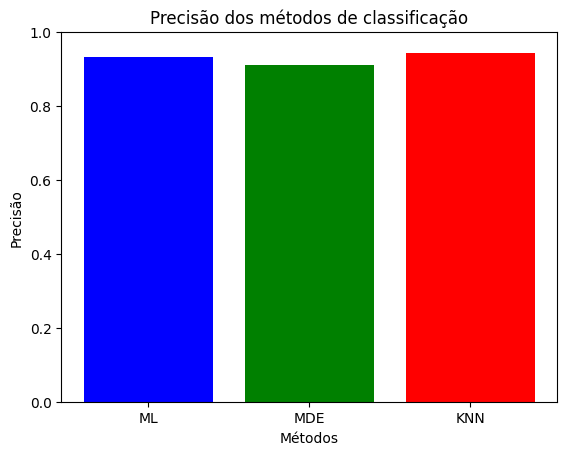

In [16]:
# Plotar os resultados
methods = ['ML', 'MDE', 'KNN']
accuracies = [acertoML, acertoMDE, acertoKNN]

plt.bar(methods, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Métodos')
plt.ylabel('Precisão')
plt.title('Precisão dos métodos de classificação')
plt.ylim([0, 1])
plt.show()